In [2]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget
import os
from scipy.signal import savgol_filter
from scipy.optimize import root
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib import ticker

In [3]:
'''defaults for plotting + some util fxns'''
fontsize_legend = 20
fontsize_axes = 24
fontsize_ticks = 16
linewidth_all = 3
markersize_all = 10
size_extra = 4

figsize_whole = (6,5)
figsize_three = (15,5)
figsize_three_vert = (6, 13)
figsize_two = (10,5)
figsize_four_vert = (8, 17)
folder_out = 'figures_ses'
folder_exp = 'exp_results'

# color_2folds = 'palevioletred'
color_2folds = 'goldenrod'
color_3folds = 'firebrick'
color_4folds = 'steelblue'
# color_4folds = 'deepskyblue'

colors_all = [color_2folds, color_3folds, color_4folds]

def smooth_pv_data(pressure, window_len = 100):
    # window_len = 100
    poly_order = 2
    len_pressure, num_exp = np.shape(pressure)

    pressure_smooth = np.zeros((len_pressure, num_exp))

    for i in range(num_exp):
        pressure_smooth[:,i] = savgol_filter(pressure[:,i], window_len, poly_order)
    
    return pressure_smooth

def rescale_eigenvalue(eigenvalues_cur):
    return np.sign(eigenvalues_cur) * np.sqrt(np.abs(eigenvalues_cur)) * 1/(2*np.pi)

def highlight_mode(freq_all, initial_i, initial_j, num_samp, num_pts = 2, select_fac = 1):
    j_all = np.zeros(np.shape(freq_all)[0], dtype = int)
    i_all = np.arange(np.shape(freq_all)[0], dtype = int)
    j_all[initial_i] = initial_j
    cut_idx = initial_i[0] + np.arange(num_samp + 2)

    for idx in range(0, num_samp, select_fac):
        i_next = idx + initial_i[1] + select_fac #min value 2

        if idx <= select_fac * (num_pts - 2): num_pts_temp = 2
        else: num_pts_temp = num_pts

        if idx == 0: i_cur = [i_next - select_fac - 1, i_next - select_fac]
        else: i_cur = [i_next - select_fac * (num_pts_temp - i) for i in range(num_pts_temp)]
        j_cur = [j_all[i] for i in i_cur]
        
        vals_cur = np.array([freq_all[i,j] for i,j in zip(i_cur, j_cur)])

        if idx == 0: val_new_est = vals_cur[-1] + select_fac * np.mean(np.diff(vals_cur))
        else: val_new_est = vals_cur[-1] + np.mean(np.diff(vals_cur))

        j_all[i_next] = np.argmin(np.abs(freq_all[i_next,:] - val_new_est))

        if select_fac > 1:
            j_all[i_cur[-1] + 1:i_next] = int(np.mean([j_all[i_cur[-1]], j_all[i_next]]))
    return (i_all, j_all, cut_idx)


In [25]:
'''fxns to plot exp/sim pv/dv/freq'''
def plot_exp_pv(axis, num_folds):
    color = colors_all[num_folds - 2]

    data_all = np.load(f'{folder_exp}/PV_{num_folds}folds_processed.npz')
    axis.plot(data_all['vol_norm'], data_all['pressure'], '--', label = 'Experiment', linewidth = linewidth_all, color = color)
    axis.fill_between(data_all['vol_norm'], data_all['pressure'] + data_all['pressure_std'], data_all['pressure'] - data_all['pressure_std'], alpha = 0.3, color = color)

def plot_sim_pv(axis, num_folds, idx_end = 0, static = False, color = None):
    if color is None: color = colors_all[num_folds - 2]
    if static:
        data = np.load(f'{folder_out}/sim_{num_folds}folds_data_static.npz')
        # data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    else:
        data = np.load(f'{folder_out}/sim_{num_folds}folds_data.npz')
    idx_end = idx_end + len(data['vol_norm'])
    
    axis.plot(data['vol_norm'][:idx_end], data['pressure'][:idx_end], label = 'FEM', color = color, linewidth = linewidth_all)

def plot_exp_dv(axes, num_folds, select_fac = 1, offset_plots = 0, plot_prop = 'both'):
    color = colors_all[num_folds - 2]
    data_all = np.load(f'{folder_exp}/DV_{num_folds}folds_processed.npz')

    if plot_prop == 'both' or plot_prop == 'contraction':
        axes[0 + offset_plots].plot(data_all['vol_norm'][::select_fac], 100 * data_all['contraction'][::select_fac], '--', label = 'Experiment', linewidth = linewidth_all, color = color)
        axes[0 + offset_plots].fill_between(data_all['vol_norm'][::select_fac], 100 * (data_all['contraction'][::select_fac] + data_all['contraction_std'][::select_fac]), 100 * (data_all['contraction'][::select_fac] - data_all['contraction_std'][::select_fac]), alpha = 0.3, color = color)

    if plot_prop == 'both' or plot_prop == 'twist':
        axes[1 + offset_plots].plot(data_all['vol_norm'][::select_fac], data_all['twist'][::select_fac], '--', label = 'Experiment', linewidth = linewidth_all, color = color)
        axes[1 + offset_plots].fill_between(data_all['vol_norm'][::select_fac], data_all['twist'][::select_fac] + data_all['twist_std'][::select_fac], data_all['twist'][::select_fac] - data_all['twist_std'][::select_fac], alpha = 0.3, color = color)

def plot_sim_dv(axes, num_folds, flip = 1, idx_end = 0, static = False, color = None, offset_plots = 0, plot_prop = 'both'):
    if color is None: color = colors_all[num_folds - 2]
    
    if static:
        # data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
        data = np.load(f'{folder_out}/sim_{num_folds}folds_data_static.npz')
    else:
        data = np.load(f'{folder_out}/sim_{num_folds}folds_data.npz')
    idx_end = idx_end + len(data['vol_norm'])
    if plot_prop == 'both' or plot_prop == 'contraction':
        axes[0 + offset_plots].plot(data['vol_norm'][:idx_end], 100 * data['contraction_strain'][:idx_end], label = 'FEM', color = color, linewidth = linewidth_all)
    if plot_prop == 'both' or plot_prop == 'twist':
        axes[1 + offset_plots].plot(data['vol_norm'][:idx_end], flip * data['twist_deg'][:idx_end], label = 'FEM', color = color, linewidth = linewidth_all)

def plot_freq(axis, num_folds, rescale = True, alpha = 0.1):
    color = colors_all[num_folds - 2]
    data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    for j in range(np.shape(data['eigval'])[1]):
        if rescale: freq_plot = data['eigval_rescale'][:,j]
        else: freq_plot = data['eigval'][:,j]
        # axis.plot(data['vol_norm'], freq_plot, '--', color = color, linewidth = linewidth_all, alpha = alpha)
        axis.plot(data['vol_norm_freq'], freq_plot, '.', color = color, markersize = markersize_all, alpha = alpha)

def plot_highlighted_mode(axis, num_folds, rescale = True, i_initial = None, j_initial = None, idx_end = -1, num_pts = 2, select_fac = 1, color = None):
    extra_thickness = 3
    if color is None: color = colors_all[num_folds - 2]
    data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    num_samp = int((np.shape(data['eigval'])[0] - i_initial[-1] + idx_end))
    i_all, j_all, cut_idx = highlight_mode(data['eigval'], i_initial, j_initial, num_samp, num_pts = num_pts, select_fac = select_fac)
    if rescale: mode_plot = rescale_eigenvalue(data['eigval'][i_all[cut_idx],j_all[cut_idx]])
    else: mode_plot = data['eigval'][i_all[cut_idx],j_all[cut_idx]]
    # axis.plot(data['vol_norm'][i_all[cut_idx]], mode_plot, 'o', color = color, linewidth = linewidth_all + extra_thickness)
    axis.plot(data['vol_norm_freq'][i_all[cut_idx]], mode_plot, color = color, linewidth = linewidth_all + extra_thickness)
    return i_all[cut_idx[-1]]

def make_highlighted_mode(num_folds, i_initial = None, j_initial = None, idx_end = -1, num_pts = 2, select_fac = 1, color = None):
    if color is None: color = colors_all[num_folds - 2]
    data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    num_samp = int((np.shape(data['eigval'])[0] - i_initial[-1] + idx_end))
    i_all, j_all, cut_idx = highlight_mode(data['eigval'], i_initial, j_initial, num_samp, num_pts = num_pts, select_fac = select_fac)
    return (i_all[cut_idx[-1]], data['vol_norm_freq'][i_all[cut_idx]], data['eigval'][i_all[cut_idx],j_all[cut_idx]])

def plot_single_mode(axis, num_folds, vol_data, eig_data, rescale = True, color = None, extra_thickness = 3):
    if color is None: color = colors_all[num_folds - 2]
    if rescale: mode_plot = rescale_eigenvalue(eig_data)
    else: mode_plot = eig_data

    axis.plot(vol_data, mode_plot, color = color, linewidth = linewidth_all + extra_thickness)
    return np.nanargmin(eig_data)
    
    
def plot_highlighted_mode_piecewise(axis, num_folds, i_initial_0, j_initial_all, num_pts_all, select_fac_all, idx_end_all, vert_line = False, rescale = True, extra_thickness = 3, color_vert_line = None, pts_plot = None):
    color = colors_all[num_folds - 2]
    vol_all = []
    eig_all = []
    i_initial = i_initial_0

    for i in range(len(j_initial_all)):
        idx_paste, vol_data, eig_data = make_highlighted_mode(num_folds, i_initial = i_initial, j_initial = j_initial_all[i], num_pts = num_pts_all[i], select_fac = select_fac_all[i], idx_end = idx_end_all[i])
        i_initial = [idx_paste, idx_paste + 1]
        if i == 0:
            vol_all.extend(vol_data)
            eig_all.extend(eig_data)
        else:
            vol_all.extend(vol_data[1:])
            eig_all.extend(eig_data[1:])
    min_loc = plot_single_mode(axis, num_folds, vol_all, eig_all, rescale = rescale, extra_thickness = extra_thickness)
    if pts_plot is not None:
        plot_pts_freq(axis, num_folds, frames = pts_plot, volume = vol_all, highlighted_mode = eig_all)
    if vert_line:
        plot_vert_line_freq(axis, num_folds, min_loc, alpha = 0.3, color = color_vert_line)
    np.savetxt(f'{folder_out}/{num_folds}folds_twist_eig.txt', np.array([vol_all,eig_all]).T, header = '\Delta V/V_0 | eigenvalue')
    return vol_all[min_loc]

def plot_vert_line_freq(axis, num_folds, idx_vert, alpha = 1, color = None):
    if color is None: color = 'k'
    data = np.load(f'{folder_out}/sim_{num_folds}folds_freq.npz')
    ylim_cur = axis.get_ylim()
    if ylim_cur[0] < 0: fac_mult = 2
    else: fac_mult = 0.5

    print(f"{num_folds}folds twist onset: \Delta V/V_0 = {data['vol_norm_freq'][idx_vert]:.3f}")
    axis.vlines(data['vol_norm_freq'][idx_vert], ylim_cur[0]*fac_mult, ylim_cur[1]*2, color = color, linestyles = 'dashed', linewidth = linewidth_all, alpha = alpha)

def plot_pts_freq(axis, num_folds, frames, volume, highlighted_mode):
    color = colors_all[num_folds - 2]

    frames = np.array(frames, dtype = int)
    volume = np.array(volume)
    highlighted_mode = np.array(highlighted_mode)
    axis.plot(volume[frames], highlighted_mode[frames], '.', color = color, markersize = markersize_all + 4)

def plot_vert_line(axis, x_val, alpha = 1, color = None):
    if color is None: color = 'k'
    ylim_cur = axis.get_ylim()
    if ylim_cur[0] < 0: fac_mult = 2
    else: fac_mult = 0.5

    axis.vlines(x_val, ylim_cur[0]*fac_mult, ylim_cur[1]*2, color = color, linestyles = 'dashed', linewidth = linewidth_all, alpha = alpha)

def plot_lin_mode(axis, num_folds, color = None, extra_thickness = 5):
    if color is None: color = colors_all[num_folds - 2]
    data_all = np.load(f'{folder_out}/sim_{num_folds}folds_lin_data.npz')

    x_plot = np.append(data_all['x_plot'], data_all['x_plot'][0])
    y_plot = np.append(data_all['y_plot'], data_all['y_plot'][0])

    axis.plot(x_plot, y_plot, linewidth = linewidth_all + extra_thickness, color = color)
    axis.set_aspect('equal', 'box')
    axis.axis('off')
    axis.get_xaxis().set_ticks([])
    axis.get_yaxis().set_ticks([])

    

In [5]:
'''improve plot fxns'''
def improve_plot_multi(axis, xlabel = '', ylabel = '', ylim_top = None, ylim_bottom = None, xlim_left = None, xlim_right = None, sharex = False, sharey = False):
    if isinstance(axis, np.ndarray):
        #is a list, do list things
        if not isinstance(xlabel, list): xlabel = [xlabel] * len(axis)
        if not isinstance(ylabel, list): ylabel = [ylabel] * len(axis)
        if not isinstance(ylim_top, list): ylim_top = [ylim_top] * len(axis)
        if not isinstance(ylim_bottom, list): ylim_bottom = [ylim_bottom] * len(axis)
        if not isinstance(xlim_left, list): xlim_left = [xlim_left] * len(axis)
        if not isinstance(xlim_right, list): xlim_right = [xlim_right] * len(axis)

        for i in range(len(axis)):
            axis[i].tick_params(labelsize = fontsize_ticks)
        
        if axis[0].get_gridspec().ncols > 1:
            #single row, assuming set ylabel on [0] only unless sharey is False
            for i in range(len(axis)):
                if i == 0 or not sharey:
                    improve_plot(axis[i], xlabel = xlabel[i], ylabel = ylabel[i], ylim_top = ylim_top[i], ylim_bottom = ylim_bottom[i], xlim_left = xlim_left[i], xlim_right = xlim_right[i])
                else:
                    improve_plot(axis[i], xlabel = xlabel[i], xlim_left = xlim_left[i], xlim_right = xlim_right[i])
                    
        else:
            #single col
            for i in range(len(axis)):
                if i == len(axis)-1 or not sharex:
                    improve_plot(axis[i], xlabel = xlabel[i], ylabel = ylabel[i], ylim_top = ylim_top[i], ylim_bottom = ylim_bottom[i], xlim_left = xlim_left[i], xlim_right = xlim_right[i])
                else:
                    improve_plot(axis[i], ylabel = ylabel[i], ylim_top = ylim_top[i], ylim_bottom = ylim_bottom[i])
    else:
        #is just ax by itself
        improve_plot(axis, xlabel = xlabel, ylabel = ylabel, ylim_top = ylim_top, ylim_bottom = ylim_bottom, xlim_left = xlim_left, xlim_right = xlim_right)

def improve_plot(axis, xlabel = '', ylabel = '', ylim_top = None, ylim_bottom = None, xlim_left = None, xlim_right = None):
    #is just ax by itself
    axis.set_ylim(top = ylim_top, bottom = ylim_bottom)
    axis.set_xlim(left = xlim_left, right = xlim_right)
    axis.set_ylabel(ylabel, fontsize = fontsize_axes)
    axis.set_xlabel(xlabel, fontsize = fontsize_axes)
    axis.tick_params(labelsize = fontsize_ticks)

In [6]:
'''fxns for find n/p_cr'''
def find_n(R,t,H):
    v1 = R/float(H)
    v2 = t/float(R)
    print(f'({(v2*v1):.3f}, {v1:.3f})')
    nu = 0.5

    n_all = [2,3,4,5,6]

    p_cr = lambda n: ((np.pi*v1)**2 + n**2)**2 * v2**3 / (12 * (1-nu**2) * n**2) + (np.pi*v1)**4 * v2/(n**2 * ((np.pi*v1)**2 + n**2)**2)

    p_cr_all = [p_cr(n) for n in n_all]
    return np.argmin(p_cr_all) + 2


def find_n_alt(v_R, v_t):
    v1 = v_R
    v2 = v_t / v_R
    print(v2)
    # print(f'({v1:.3f},{v2:.3f})')
    nu = 0.5

    n_all = [2,3,4,5,6]

    p_cr = lambda n: ((np.pi*v1)**2 + n**2)**2 * v2**3 / (12 * (1-nu**2) * n**2) + (np.pi*v1)**4 * v2/(n**2 * ((np.pi*v1)**2 + n**2)**2)
    

    p_cr_all = [p_cr(n) for n in n_all]
    return n_all[np.argmin(p_cr_all)]

def find_pcr_n_alt(v_R, v_t):
    v1 = v_R
    v2 = v_t / v_R
    # print(f'({v1:.3f},{v2:.3f})')
    nu = 0.5

    n_all = [2,3,4,5,6]

    p_cr = lambda n: ((np.pi*v1)**2 + n**2)**2 * v2**3 / (12 * (1-nu**2) * n**2) + (np.pi*v1)**4 * v2/(n**2 * ((np.pi*v1)**2 + n**2)**2)

    p_cr_all = [p_cr(n) for n in n_all]
    idx_min = np.argmin(p_cr_all)
    return (n_all[idx_min], p_cr_all[idx_min])



In [7]:
'''calc n and p_cr for heat maps'''
num_try_R = 400
num_try_t = 400

n_all = np.zeros((num_try_R, num_try_t), dtype = int)
p_cr_all = np.zeros((num_try_R, num_try_t))

v_R_try = np.linspace(0.1,0.6, num_try_R)
v_t_try = np.linspace(0.01,0.05, num_try_t)

for i,v_R in enumerate(v_R_try):
    for j,v_t in enumerate(v_t_try):
        n_cur, p_cr_cur = find_pcr_n_alt(v_R, v_t)
        n_all[i,j] = int(n_cur)
        p_cr_all[i,j] = p_cr_cur

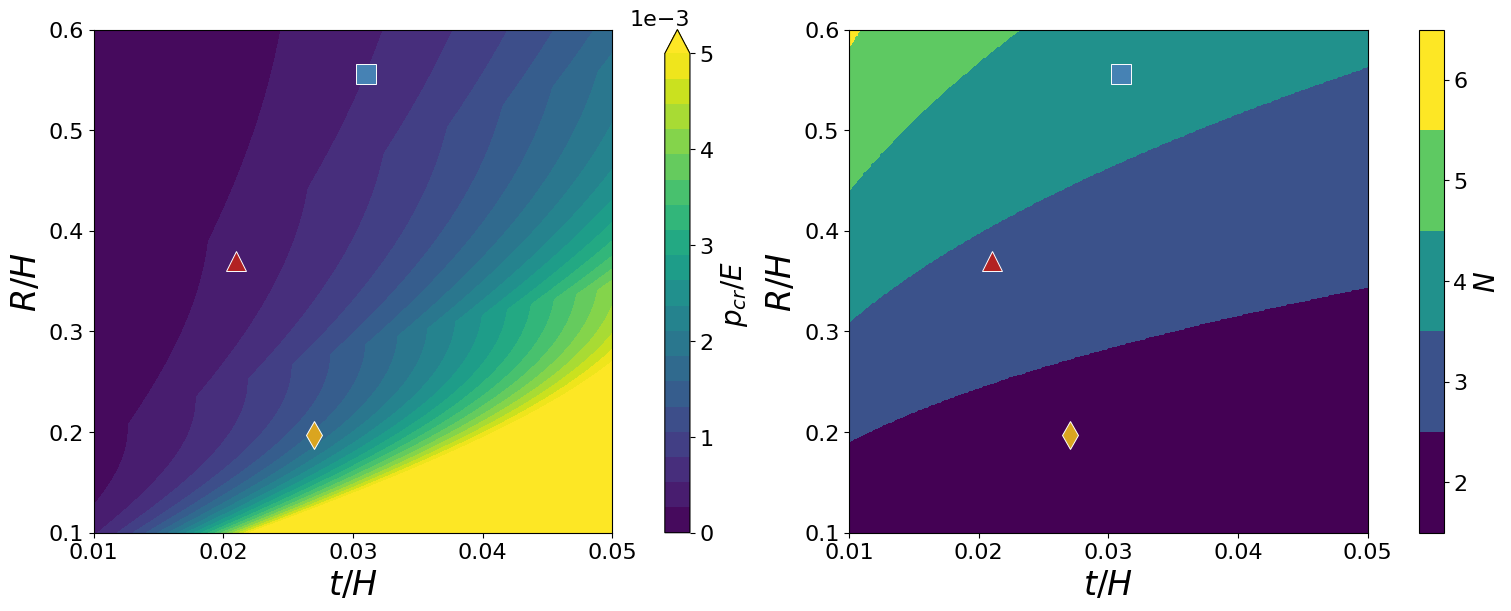

In [8]:
fig, ax = plt.subplots(1,2, figsize = (15, 6), constrained_layout = True)

plot_pts = True

edge_width_all = 0.7
cmap_use = 'viridis'
# ax.imshow(res_all)
if plot_pts:
    ax[0].plot(0.031, 0.556, 's', color = 'w', markerfacecolor = color_4folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
    ax[0].plot(0.027, 0.197, 'd', color = 'w', markerfacecolor = color_2folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
    ax[0].plot(0.021, 0.370, '^', color = 'w', markerfacecolor = color_3folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
num_values = np.unique(n_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')
levels_set = np.linspace(0,0.005,20)
map_thing = ax[0].contourf(yv, xv, p_cr_all, levels = levels_set, cmap = cmap_use, extend = 'max')



cbar = fig.colorbar(map_thing, extend = 'max', ticks=[0, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3], pad = -0.015)
cbar.set_label(label = '$p_{cr}/E$', size = fontsize_legend)
cbar.ax.ticklabel_format(scilimits = (-2,3))
cbar.ax.tick_params(labelsize=fontsize_ticks)
cbar.ax.yaxis.offsetText.set_fontsize(fontsize_ticks)

############################

if plot_pts:
    ax[1].plot(0.031, 0.556, 's', color = 'w', markerfacecolor = color_4folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
    ax[1].plot(0.027, 0.197, 'd', color = 'w', markerfacecolor = color_2folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
    ax[1].plot(0.021, 0.370, '^', color = 'w', markerfacecolor = color_3folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
num_values = np.unique(n_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')
levels_set = np.arange(6) + 1.5
map_thing = ax[1].contourf(yv, xv, n_all, levels = levels_set, cmap = cmap_use, vmin = 2, vmax = 6)



cbar = fig.colorbar(map_thing, ticks=[2,3,4,5,6], pad = 0.05)
cbar.ax.tick_params(labelsize=fontsize_ticks)
cbar.set_label(label = '$N$', size = fontsize_legend)

for axis in ax:
    axis.set_xlabel('$t/H$', fontsize = fontsize_axes)
    axis.set_ylabel('$R/H$', fontsize = fontsize_axes)
    axis.tick_params(labelsize = fontsize_ticks)
    axis.set_xlim(np.min(v_t_try), np.max(v_t_try))
    axis.set_ylim(np.min(v_R_try), np.max(v_R_try))

fig.savefig(f'{folder_out}/fig1_model_linspace_pts_{plot_pts}.png', dpi = 300)

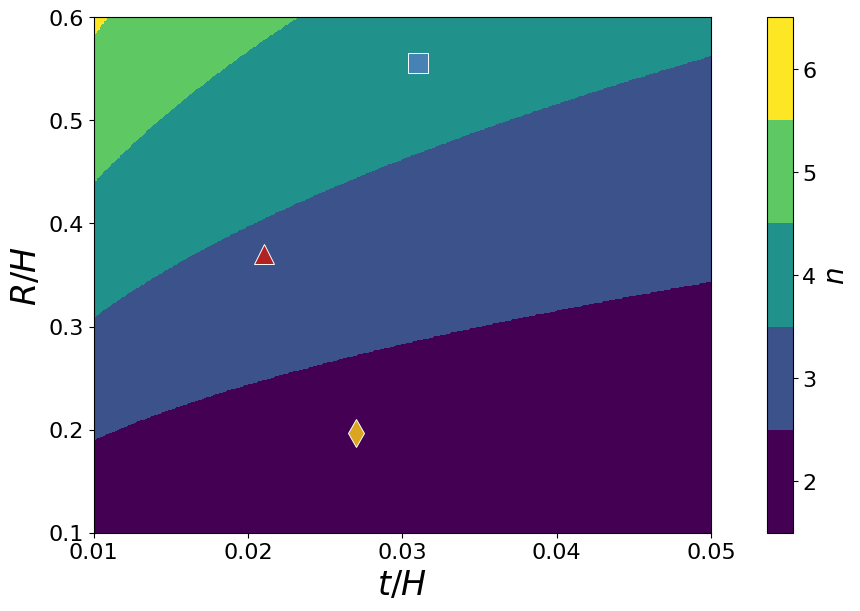

In [13]:
fig, ax = plt.subplots(figsize = (8.5, 6), constrained_layout = True)

plot_pts = 3

if plot_pts > 0:
    ax.plot(0.027, 0.197, 'd', color = 'w', markerfacecolor = color_2folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
if plot_pts > 1:
    ax.plot(0.021, 0.370, '^', color = 'w', markerfacecolor = color_3folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
if plot_pts > 2:
    ax.plot(0.031, 0.556, 's', color = 'w', markerfacecolor = color_4folds, markersize = markersize_all + size_extra, markeredgewidth = edge_width_all)
num_values = np.unique(n_all)
xv, yv = np.meshgrid(v_R_try, v_t_try, indexing='ij')
levels_set = np.arange(6) + 1.5
map_thing = ax.contourf(yv, xv, n_all, levels = levels_set, cmap = cmap_use, vmin = 2, vmax = 6)



cbar = fig.colorbar(map_thing, ticks=[2,3,4,5,6], pad = 0.05)
cbar.ax.tick_params(labelsize=fontsize_ticks)
cbar.set_label(label = '$n$', size = fontsize_legend)

ax.set_xticks([0.01, 0.02, 0.03, 0.04, 0.05])
ax.set_xlabel('$t/H$', fontsize = fontsize_axes)
ax.set_ylabel('$R/H$', fontsize = fontsize_axes)
ax.tick_params(labelsize = fontsize_ticks)
ax.set_xlim(np.min(v_t_try), np.max(v_t_try))
ax.set_ylim(np.min(v_R_try), np.max(v_R_try))

fig.savefig(f'{folder_out}/heat_map_n_linspace_pts_{plot_pts}.png', dpi = 300)

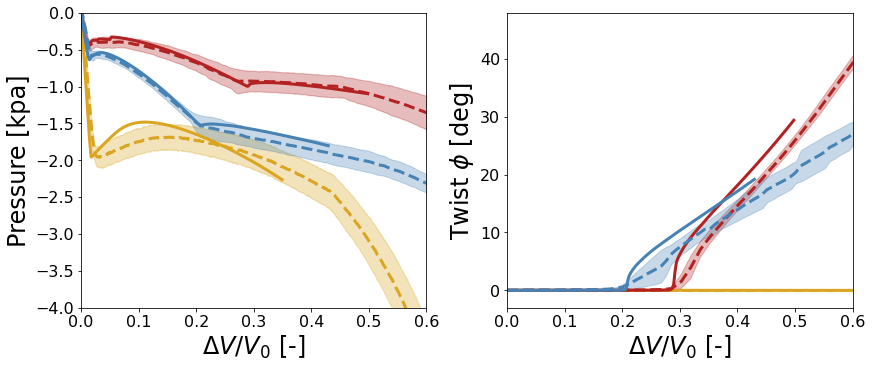

In [37]:
'''pv + twist plots'''
fig, ax = plt.subplots(1,2,figsize = (12,5), constrained_layout = True)

### twist ###
plot_exp_dv(ax, 2, 1, plot_prop = 'twist')
plot_sim_dv(ax, 2, idx_end = 0, plot_prop = 'twist')

plot_exp_dv(ax, 3, 8, plot_prop = 'twist')
plot_sim_dv(ax, 3, static = True, plot_prop = 'twist')


plot_exp_dv(ax, 4, plot_prop = 'twist')
plot_sim_dv(ax, 4, flip = -1, static = True, plot_prop = 'twist')

#### pv ####
'''2 folds'''
num_folds = 2
plot_exp_pv(ax[0], num_folds)
plot_sim_pv(ax[0], num_folds, static = True)

'''3 folds'''
num_folds = 3
plot_exp_pv(ax[0], num_folds)
plot_sim_pv(ax[0], num_folds, static = True)

'''4 folds'''
num_folds = 4
plot_exp_pv(ax[0], num_folds)
plot_sim_pv(ax[0], num_folds, static = True)

# ax[1].vlines(0.285, -10,100, 'lightcoral', '--', linewidth = linewidth_all)
# ax[1].vlines(0.204, -10,100, 'steelblue', '--', linewidth = linewidth_all)

# ax[2].vlines(0.285, -10,100, 'lightcoral', '--', linewidth = linewidth_all)
# ax[2].vlines(0.204, -10,100, 'steelblue', '--', linewidth = linewidth_all)

improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = ['Pressure [kpa]', 'Twist $\phi$ [deg]'], xlim_left = 0, xlim_right = 0.6, ylim_bottom = [-4, -3], ylim_top = [0, 48])
fig.savefig(f'{folder_out}/pv_twist.png', dpi = 300)

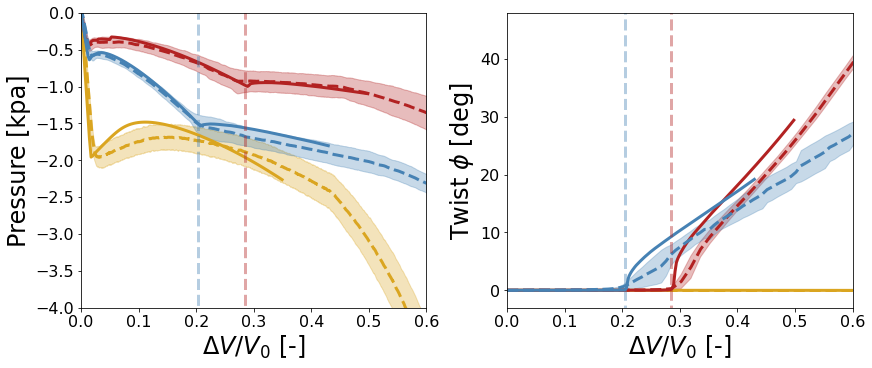

In [38]:
'''pv + twist plots'''
fig, ax = plt.subplots(1,2,figsize = (12,5), constrained_layout = True)

alpha_vline = 0.4

### twist ###
plot_exp_dv(ax, 2, 1, plot_prop = 'twist')
plot_sim_dv(ax, 2, idx_end = 0, plot_prop = 'twist')

plot_exp_dv(ax, 3, 8, plot_prop = 'twist')
plot_sim_dv(ax, 3, static = True, plot_prop = 'twist')


plot_exp_dv(ax, 4, plot_prop = 'twist')
plot_sim_dv(ax, 4, flip = -1, static = True, plot_prop = 'twist')

#### pv ####
'''2 folds'''
num_folds = 2
plot_exp_pv(ax[0], num_folds)
plot_sim_pv(ax[0], num_folds, static = True)

'''3 folds'''
num_folds = 3
plot_exp_pv(ax[0], num_folds)
plot_sim_pv(ax[0], num_folds, static = True)

'''4 folds'''
num_folds = 4
plot_exp_pv(ax[0], num_folds)
plot_sim_pv(ax[0], num_folds, static = True)

ax[0].vlines(0.285, -10,100, 'firebrick', '--', linewidth = linewidth_all, alpha = alpha_vline)
ax[0].vlines(0.204, -10,100, 'steelblue', '--', linewidth = linewidth_all, alpha = alpha_vline)

ax[1].vlines(0.285, -10,100, 'firebrick', '--', linewidth = linewidth_all, alpha = alpha_vline)
ax[1].vlines(0.204, -10,100, 'steelblue', '--', linewidth = linewidth_all, alpha = alpha_vline)

improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = ['Pressure [kpa]', 'Twist $\phi$ [deg]'], xlim_left = 0, xlim_right = 0.6, ylim_bottom = [-4, -3], ylim_top = [0, 48])
fig.savefig(f'{folder_out}/pv_twist_vlines.png', dpi = 300)

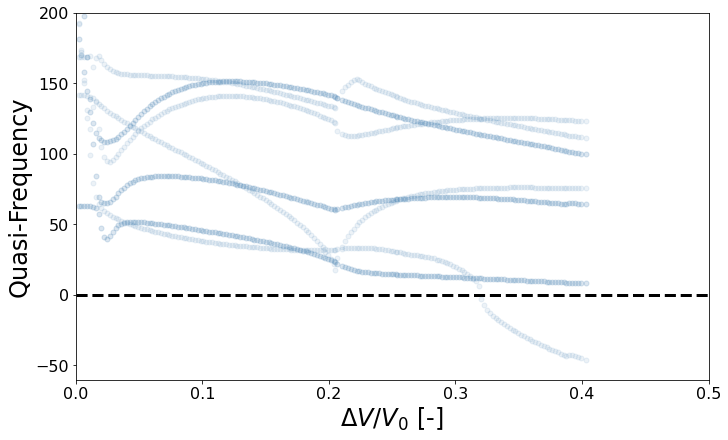

In [42]:
'current freq plots 1x1 4folds'
fig, ax = plt.subplots(figsize = (10, 6), constrained_layout = True, sharey = True)

ax.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

plot_freq(ax, 4)

improve_plot(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 200, ylim_bottom = -60, xlim_left = 0, xlim_right = 0.5)

fig.savefig(f'{folder_out}/4folds_freq.png', dpi = 300)

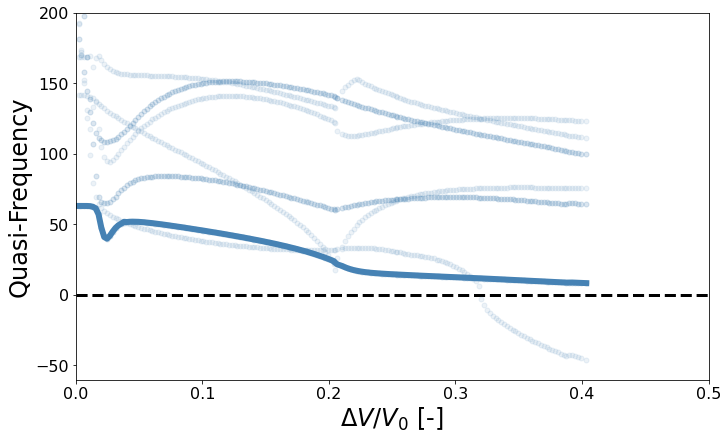

In [35]:
'current freq plots 1x1 4folds'
fig, ax = plt.subplots(figsize = (10, 6), constrained_layout = True, sharey = True)

ax.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

plot_freq(ax, 4)

#twisting:
# plot_highlighted_mode_piecewise(ax[2], 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = True)

#shear
plot_highlighted_mode_piecewise(ax, 4, [0,1], [[0,0]], [2], [1], [-1], vert_line = False)

improve_plot(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 200, ylim_bottom = -60, xlim_left = 0, xlim_right = 0.5)

fig.savefig(f'{folder_out}/4folds_freq_shear.png', dpi = 300)

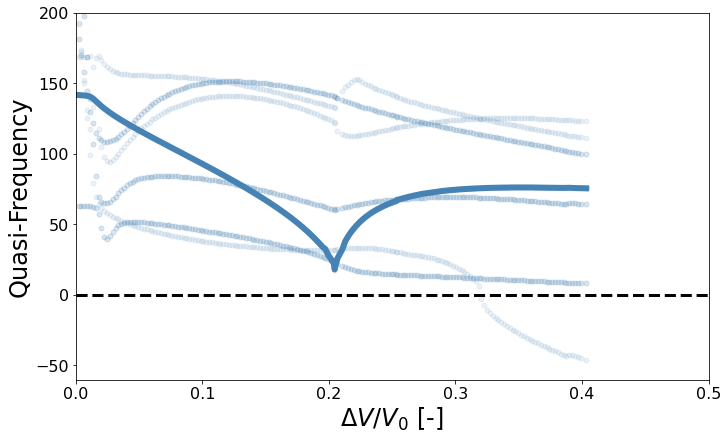

In [36]:
'current freq plots 1x1 4folds'
fig, ax = plt.subplots(figsize = (10, 6), constrained_layout = True, sharey = True)

ax.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

plot_freq(ax, 4)

#twisting:
plot_highlighted_mode_piecewise(ax, 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = False)

#shear
# plot_highlighted_mode_piecewise(ax, 4, [0,1], [[0,0]], [2], [1], [-1], vert_line = False)

improve_plot(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 200, ylim_bottom = -60, xlim_left = 0, xlim_right = 0.5)

fig.savefig(f'{folder_out}/4folds_freq_twist.png', dpi = 300)

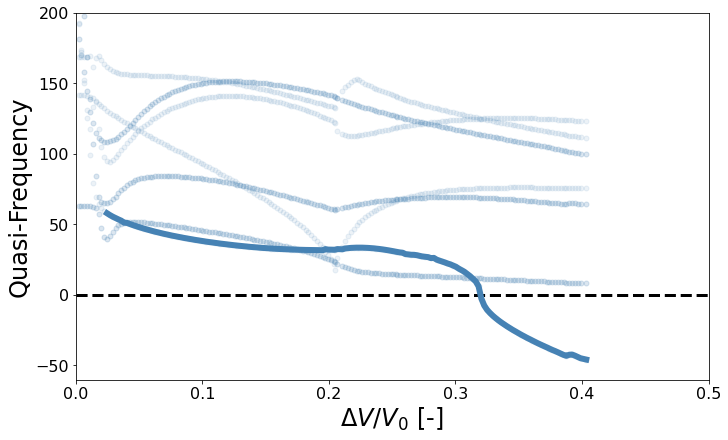

In [39]:
'current freq plots 1x1 4folds'
fig, ax = plt.subplots(figsize = (10, 6), constrained_layout = True, sharey = True)

ax.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

plot_freq(ax, 4)

#twisting:
# plot_highlighted_mode_piecewise(ax, 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = False)

#shear
# plot_highlighted_mode_piecewise(ax, 4, [0,1], [[0,0]], [2], [1], [-1], vert_line = False)

#weird
plot_highlighted_mode_piecewise(ax, 4, [10,11], [[2,2], [3,3]], [2, 3], [2, 1], [-110, -1], vert_line = False)

improve_plot(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 200, ylim_bottom = -60, xlim_left = 0, xlim_right = 0.5)

fig.savefig(f'{folder_out}/4folds_freq_weird.png', dpi = 300)

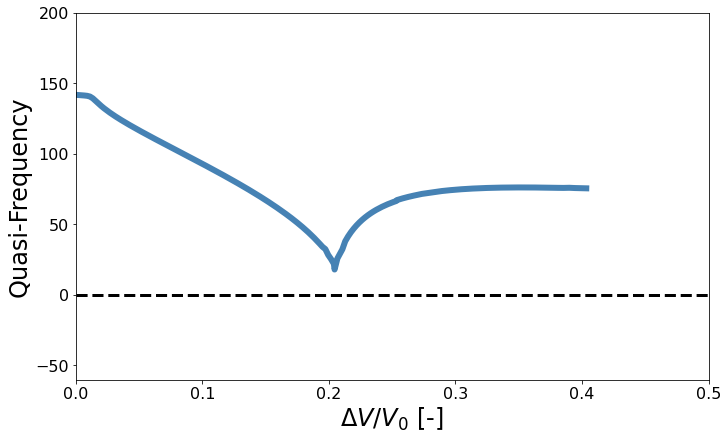

In [49]:
'current freq plots 1x1 4folds'
fig, ax = plt.subplots(figsize = (10, 6), constrained_layout = True, sharey = True)

ax.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

# plot_freq(ax, 4)

#twisting:
plot_highlighted_mode_piecewise(ax, 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = False)

#shear
# plot_highlighted_mode_piecewise(ax, 4, [0,1], [[0,0]], [2], [1], [-1], vert_line = False)

#weird
# plot_highlighted_mode_piecewise(ax, 4, [10,11], [[2,2], [3,3]], [2, 3], [2, 1], [-110, -1], vert_line = False)

improve_plot(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 200, ylim_bottom = -60, xlim_left = 0, xlim_right = 0.5)

fig.savefig(f'{folder_out}/4folds_freq_twist_only.png', dpi = 300)

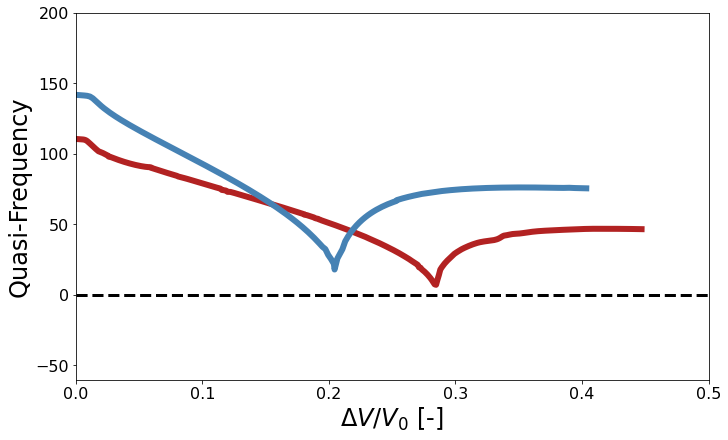

In [50]:
'current freq plots 1x1 4folds'
fig, ax = plt.subplots(figsize = (10, 6), constrained_layout = True, sharey = True)

ax.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

# plot_freq(ax, 4)

#twisting 2
# plot_highlighted_mode_piecewise(ax, 2, [0,1], [[4,4]], [2], [1], [-1])

#twisting 3
plot_highlighted_mode_piecewise(ax, 3, [0,1], [[2,2], [5,5], [3,3], [1,1]], [20, 2, 4, 2], [1, 4, 2, 1], [-320, -190, -145, -1], vert_line = False)

#twisting 4:
plot_highlighted_mode_piecewise(ax, 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = False)






improve_plot(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 200, ylim_bottom = -60, xlim_left = 0, xlim_right = 0.5)

fig.savefig(f'{folder_out}/freq_twist_only_43.png', dpi = 300)

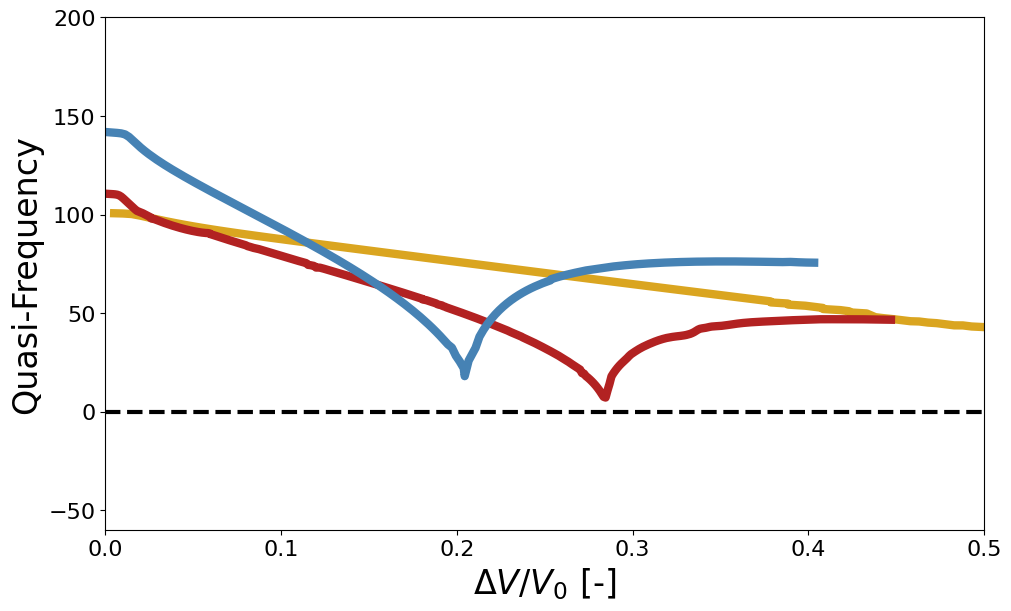

In [9]:
'current freq plots 1x1 4folds'
fig, ax = plt.subplots(figsize = (10, 6), constrained_layout = True, sharey = True)

ax.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

# plot_freq(ax, 4)

#twisting 2
plot_highlighted_mode_piecewise(ax, 2, [0,1], [[4,4]], [2], [1], [-1])

#twisting 3
plot_highlighted_mode_piecewise(ax, 3, [0,1], [[2,2], [5,5], [3,3], [1,1]], [20, 2, 4, 2], [1, 4, 2, 1], [-320, -190, -145, -1], vert_line = False)

#twisting 4:
plot_highlighted_mode_piecewise(ax, 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = False)






improve_plot(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 200, ylim_bottom = -60, xlim_left = 0, xlim_right = 0.5)

fig.savefig(f'{folder_out}/freq_twist_only_all.png', dpi = 300)

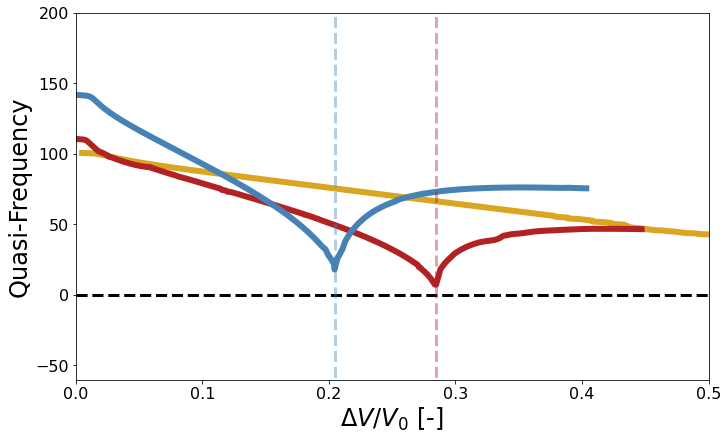

In [7]:
'current freq plots 1x1 4folds'
fig, ax = plt.subplots(figsize = (10, 6), constrained_layout = True, sharey = True)

ax.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

# plot_freq(ax, 4)

#twisting 2
plot_highlighted_mode_piecewise(ax, 2, [0,1], [[4,4]], [2], [1], [-1])

#twisting 3
min_3loc = plot_highlighted_mode_piecewise(ax, 3, [0,1], [[2,2], [5,5], [3,3], [1,1]], [20, 2, 4, 2], [1, 4, 2, 1], [-320, -190, -145, -1], vert_line = False)

#twisting 4:
min_4loc = plot_highlighted_mode_piecewise(ax, 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = False)



improve_plot(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 200, ylim_bottom = -60, xlim_left = 0, xlim_right = 0.5)

plot_vert_line(ax, min_3loc, alpha = 0.4, color = color_3folds)
plot_vert_line(ax, min_4loc, alpha = 0.4, color = color_4folds)

fig.savefig(f'{folder_out}/freq_twist_only_all_vert_lines.png', dpi = 300)

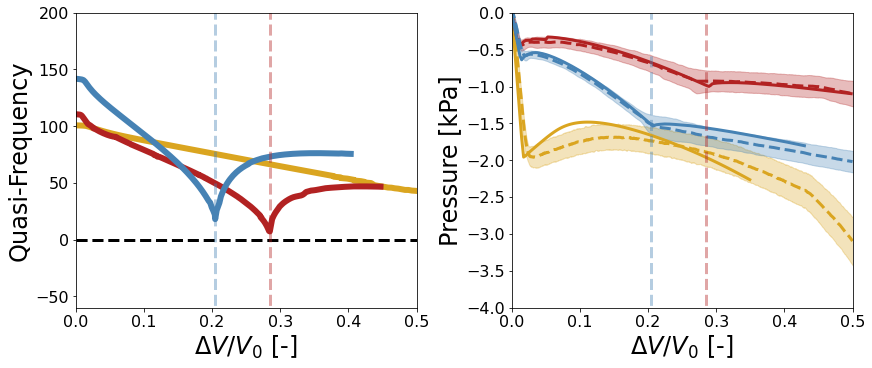

In [39]:
'freq vs pv'
fig, ax = plt.subplots(1,2,figsize = (12,5), constrained_layout = True)

ax[0].hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

# plot_freq(ax, 4)

#twisting 2
plot_highlighted_mode_piecewise(ax[0], 2, [0,1], [[4,4]], [2], [1], [-1])

#twisting 3
min_3loc = plot_highlighted_mode_piecewise(ax[0], 3, [0,1], [[2,2], [5,5], [3,3], [1,1]], [20, 2, 4, 2], [1, 4, 2, 1], [-320, -190, -145, -1], vert_line = False)

#twisting 4:
min_4loc = plot_highlighted_mode_piecewise(ax[0], 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = False)


#### pv ####
'''2 folds'''
num_folds = 2
plot_exp_pv(ax[1], num_folds)
plot_sim_pv(ax[1], num_folds, static = True)

'''3 folds'''
num_folds = 3
plot_exp_pv(ax[1], num_folds)
plot_sim_pv(ax[1], num_folds, static = True)

'''4 folds'''
num_folds = 4
plot_exp_pv(ax[1], num_folds)
plot_sim_pv(ax[1], num_folds, static = True)


improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = ['Quasi-Frequency', 'Pressure [kPa]'], ylim_top = [200, 0], ylim_bottom = [-60, -4], xlim_left = 0, xlim_right = 0.5)

for axis in ax:
    plot_vert_line(axis, min_3loc, alpha = 0.4, color = color_3folds)
    plot_vert_line(axis, min_4loc, alpha = 0.4, color = color_4folds)

fig.savefig(f'{folder_out}/freq_twist_only_pv.png', dpi = 300)

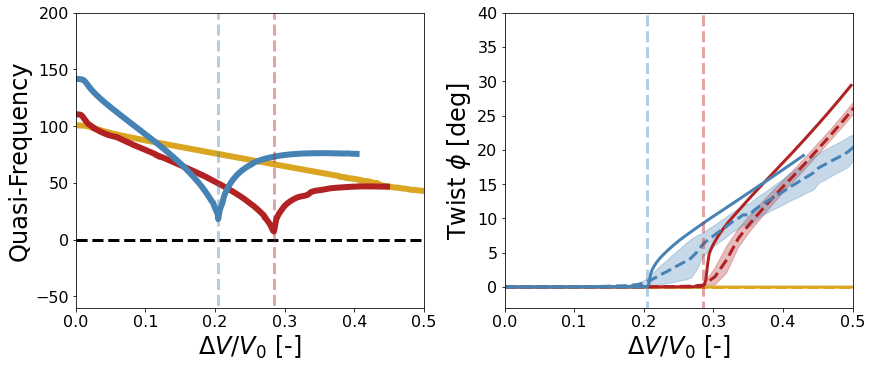

In [40]:
'freq vs twist'
fig, ax = plt.subplots(1,2,figsize = (12,5), constrained_layout = True)

ax[0].hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

# plot_freq(ax, 4)

#twisting 2
plot_highlighted_mode_piecewise(ax[0], 2, [0,1], [[4,4]], [2], [1], [-1])

#twisting 3
min_3loc = plot_highlighted_mode_piecewise(ax[0], 3, [0,1], [[2,2], [5,5], [3,3], [1,1]], [20, 2, 4, 2], [1, 4, 2, 1], [-320, -190, -145, -1], vert_line = False)

#twisting 4:
min_4loc = plot_highlighted_mode_piecewise(ax[0], 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = False)


### twist ###
plot_exp_dv(ax, 2, 1, plot_prop = 'twist')
plot_sim_dv(ax, 2, idx_end = 0, plot_prop = 'twist')

plot_exp_dv(ax, 3, 8, plot_prop = 'twist')
plot_sim_dv(ax, 3, static = True, plot_prop = 'twist')


plot_exp_dv(ax, 4, plot_prop = 'twist')
plot_sim_dv(ax, 4, flip = -1, static = True, plot_prop = 'twist')



improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = ['Quasi-Frequency', 'Twist $\phi$ [deg]'], ylim_top = [200, 40], ylim_bottom = [-60, -3], xlim_left = 0, xlim_right = 0.5)

for axis in ax:
    plot_vert_line(axis, min_3loc, alpha = 0.4, color = color_3folds)
    plot_vert_line(axis, min_4loc, alpha = 0.4, color = color_4folds)

fig.savefig(f'{folder_out}/freq_twist_only_twist.png', dpi = 300)

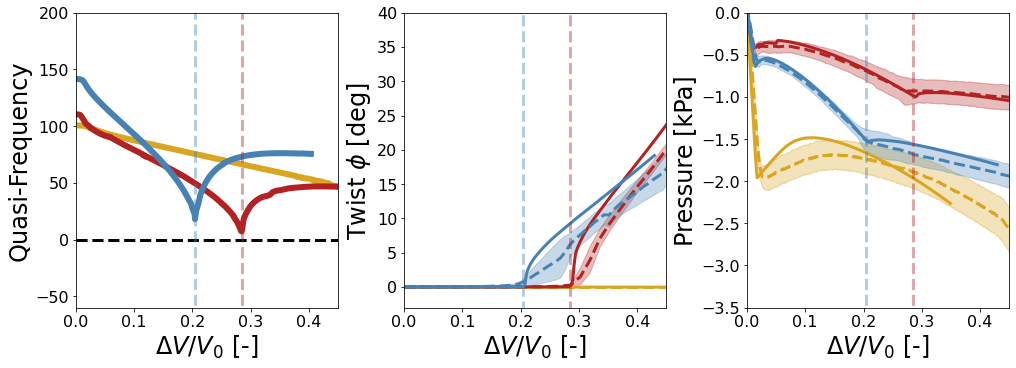

In [48]:
'freq vs pv vs twist'
fig, ax = plt.subplots(1,3,figsize = (14,5), constrained_layout = True)

ax[0].hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

# plot_freq(ax, 4)

#twisting 2
plot_highlighted_mode_piecewise(ax[0], 2, [0,1], [[4,4]], [2], [1], [-1])

#twisting 3
min_3loc = plot_highlighted_mode_piecewise(ax[0], 3, [0,1], [[2,2], [5,5], [3,3], [1,1]], [20, 2, 4, 2], [1, 4, 2, 1], [-320, -190, -145, -1], vert_line = False)

#twisting 4:
min_4loc = plot_highlighted_mode_piecewise(ax[0], 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = False)


### twist ###
plot_exp_dv(ax, 2, 1, plot_prop = 'twist')
plot_sim_dv(ax, 2, idx_end = 0, plot_prop = 'twist')

plot_exp_dv(ax, 3, 8, plot_prop = 'twist')
plot_sim_dv(ax, 3, static = True, plot_prop = 'twist')


plot_exp_dv(ax, 4, plot_prop = 'twist')
plot_sim_dv(ax, 4, flip = -1, static = True, plot_prop = 'twist')


#### pv ####
'''2 folds'''
num_folds = 2
plot_exp_pv(ax[2], num_folds)
plot_sim_pv(ax[2], num_folds, static = True)

'''3 folds'''
num_folds = 3
plot_exp_pv(ax[2], num_folds)
plot_sim_pv(ax[2], num_folds, static = True)

'''4 folds'''
num_folds = 4
plot_exp_pv(ax[2], num_folds)
plot_sim_pv(ax[2], num_folds, static = True)

improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = ['Quasi-Frequency', 'Twist $\phi$ [deg]', 'Pressure [kPa]'], ylim_top = [200, 40, 0], ylim_bottom = [-60, -3, -3.5], xlim_left = 0, xlim_right = 0.45)

for axis in ax:
    plot_vert_line(axis, min_3loc, alpha = 0.4, color = color_3folds)
    plot_vert_line(axis, min_4loc, alpha = 0.4, color = color_4folds)

fig.savefig(f'{folder_out}/freq_twist_only_all_twist_pv.png', dpi = 300)

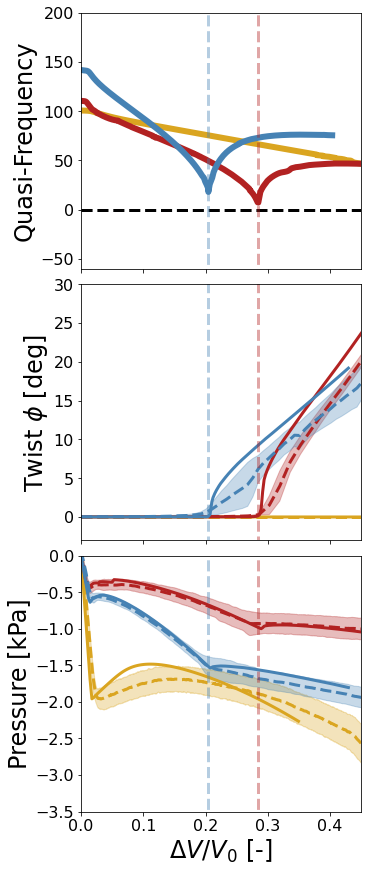

In [52]:
'freq vs pv vs twist'
fig, ax = plt.subplots(3,1,figsize = (5, 12), constrained_layout = True, sharex = True)

ax[0].hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

# plot_freq(ax, 4)

#twisting 2
plot_highlighted_mode_piecewise(ax[0], 2, [0,1], [[4,4]], [2], [1], [-1])

#twisting 3
min_3loc = plot_highlighted_mode_piecewise(ax[0], 3, [0,1], [[2,2], [5,5], [3,3], [1,1]], [20, 2, 4, 2], [1, 4, 2, 1], [-320, -190, -145, -1], vert_line = False)

#twisting 4:
min_4loc = plot_highlighted_mode_piecewise(ax[0], 4, [0,1], [[2,2], [0,2]], [4,2], [1,1], [-109, -1], vert_line = False)


### twist ###
plot_exp_dv(ax, 2, 1, plot_prop = 'twist')
plot_sim_dv(ax, 2, idx_end = 0, plot_prop = 'twist')

plot_exp_dv(ax, 3, 8, plot_prop = 'twist')
plot_sim_dv(ax, 3, static = True, plot_prop = 'twist')


plot_exp_dv(ax, 4, plot_prop = 'twist')
plot_sim_dv(ax, 4, flip = -1, static = True, plot_prop = 'twist')


#### pv ####
'''2 folds'''
num_folds = 2
plot_exp_pv(ax[2], num_folds)
plot_sim_pv(ax[2], num_folds, static = True)

'''3 folds'''
num_folds = 3
plot_exp_pv(ax[2], num_folds)
plot_sim_pv(ax[2], num_folds, static = True)

'''4 folds'''
num_folds = 4
plot_exp_pv(ax[2], num_folds)
plot_sim_pv(ax[2], num_folds, static = True)

improve_plot_multi(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = ['Quasi-Frequency', 'Twist $\phi$ [deg]', 'Pressure [kPa]'], ylim_top = [200, 30, 0], ylim_bottom = [-60, -3, -3.5], xlim_left = 0, xlim_right = 0.45, sharex = True)

for axis in ax:
    plot_vert_line(axis, min_3loc, alpha = 0.4, color = color_3folds)
    plot_vert_line(axis, min_4loc, alpha = 0.4, color = color_4folds)

fig.savefig(f'{folder_out}/freq_twist_only_all_twist_pv_vert.png', dpi = 300)

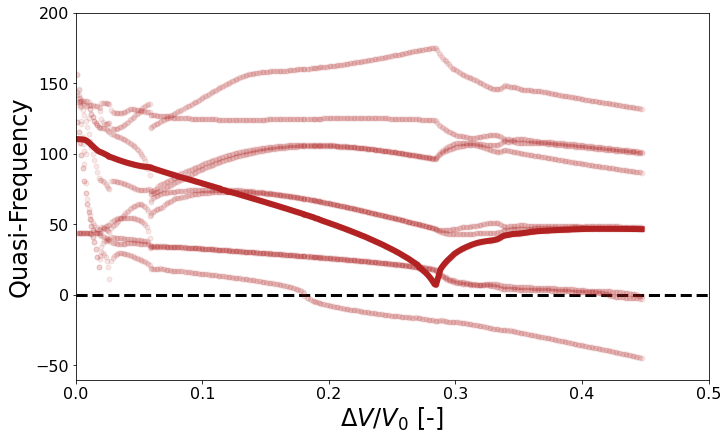

In [54]:
'''freq plot 3folds'''
fig, ax = plt.subplots(figsize = (10, 6), constrained_layout = True, sharey = True)

ax.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

plot_freq(ax, 3)

min_3loc = plot_highlighted_mode_piecewise(ax, 3, [0,1], [[2,2], [5,5], [3,3], [1,1]], [20, 2, 4, 2], [1, 4, 2, 1], [-320, -190, -145, -1], vert_line = False)

improve_plot(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 200, ylim_bottom = -60, xlim_left = 0, xlim_right = 0.5)

fig.savefig(f'{folder_out}/3folds_freq_backup.png', dpi = 300)

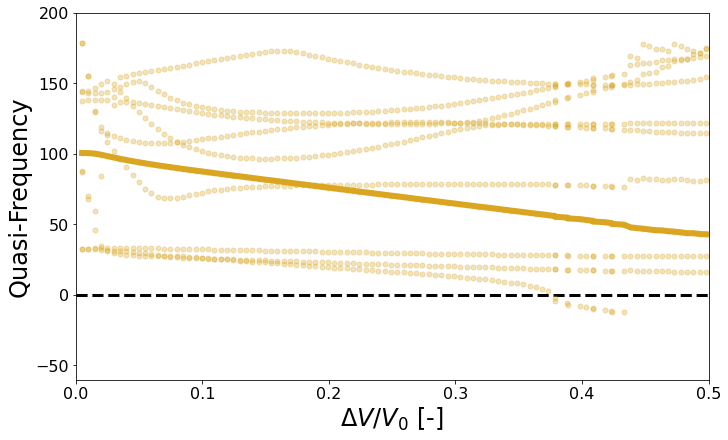

In [57]:
'''freq plot 2folds'''
fig, ax = plt.subplots(figsize = (10, 6), constrained_layout = True, sharey = True)

ax.hlines(0,0,0.5, 'k', '--', linewidth = linewidth_all)

plot_freq(ax, 2, alpha = 0.3)

#twisting 2
plot_highlighted_mode_piecewise(ax, 2, [0,1], [[4,4]], [2], [1], [-1])

improve_plot(ax, xlabel = '$\Delta V/V_0$ [-]', ylabel = 'Quasi-Frequency', ylim_top = 200, ylim_bottom = -60, xlim_left = 0, xlim_right = 0.5)

fig.savefig(f'{folder_out}/2folds_freq_backup.png', dpi = 300)



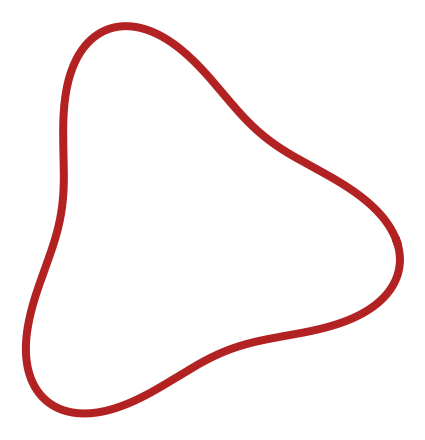

In [104]:
x_plot, y_plot = np.loadtxt('data_out/sim-long-4folds-210_coord_lin_mode.txt', unpack = True)
x_plot = np.append(x_plot, x_plot[0])
y_plot = np.append(y_plot, y_plot[0])

fig, ax = plt.subplots(figsize = (6,6), constrained_layout = True)
ax.plot(x_plot,y_plot, linewidth = linewidth_all + 5, color = color_3folds)

#linewidth_all + 5
ax.set_aspect('equal', 'box')

ax.axis('off')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
# ax.tick_params(axis = 'both', bottom = False, labelbottom = False, left = False, labelleft = False)

fig.savefig(f'{folder_out}/3folds_lin_mode.png', dpi = 300)

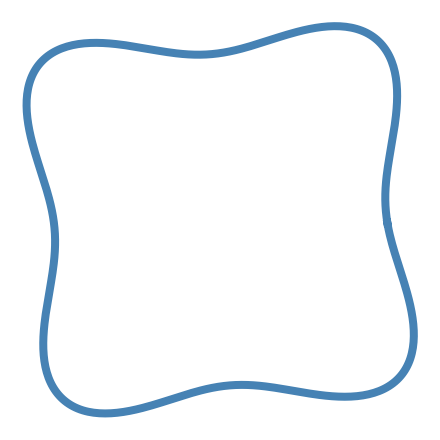

In [115]:
fig, ax = plt.subplots(figsize = (6,6), constrained_layout = True)

num_folds = 4

plot_lin_mode(ax, num_folds)
fig.savefig(f'{folder_out}/{num_folds}folds_lin_mode.png', dpi = 300)